In [111]:
import os, sys
import numpy as np
import pandas as pd

from src import settings
from src.utils import fileio


TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'CsCh']


for TREATMENT in TREATMENTS:
    INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_0_find_interactions", TREATMENT)
    
    OUTPUT_DIR = os.path.join(settings.DATA_DIR, "data", "dynam_data", TREATMENT)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    treatment = fileio.load_files_from_folder(INPUT_DIR)
    for group_name, group_path in treatment.items():

        os.makedirs(os.path.join(OUTPUT_DIR, group_name.replace('.csv','')), exist_ok=True)

        df_interactions = pd.read_csv(group_path, index_col=0)
        df_interactions = df_interactions.sort_values("start_of_interaction").reset_index(drop=True)
        duplicates = df_interactions['start_of_interaction'].duplicated(keep=False)
        duplicate_indices = df_interactions.index[duplicates]

        while not duplicate_indices.empty:
            for i in range(1, len(duplicate_indices)):
                current_idx = duplicate_indices[i]
                prev_idx = duplicate_indices[i - 1]
                
                while (
                    df_interactions.loc[current_idx, "start_of_interaction"]
                    <= df_interactions.loc[prev_idx, "start_of_interaction"]
                ):
                    df_interactions.loc[current_idx, "start_of_interaction"] += 1
        
            duplicates_new = df_interactions['start_of_interaction'].duplicated(keep=False)
            duplicate_indices = df_interactions.index[duplicates_new]

        df_interactions = df_interactions[['node_1', 'node_2', 'start_of_interaction']]
        df_interactions.columns = ['sender', 'reciver', 'time']
        df_interactions["increment"] = 1

        in_deg = [f'fly{i}_in_degree' for i in range(1,13)]
        out_deg = [f'fly{i}_out_degree' for i in range(1,13)]
        in_weighted = [f'fly{i}_in_weighted' for i in range(1,13)]
        out_weighted = [f'fly{i}_out_weighted' for i in range(1,13)]

        res = pd.DataFrame(0, index=range(28800), columns=in_deg + out_deg + in_weighted + out_weighted)
        time_window = 24 * 36
        df = df_interactions[['sender',	'reciver', 'time']]

        for idx, row in df.iterrows():
            time = row['time']
            sender = row['sender']
            reciver = row['reciver']

            df_time_window = df[(df['time'] <= time) & (df['time'] >= (time - time_window))]
            
            if len(df_time_window) > 0:
                out_degree_w = df_time_window['sender'].value_counts()
                in_degree_w = df_time_window['reciver'].value_counts()
                res.loc[time, f'{reciver}_in_weighted'] = in_degree_w[reciver]
                res.loc[time, f'{sender}_out_weighted'] = out_degree_w[sender]

                unique_interactions = df_time_window.drop_duplicates(subset=['sender', 'reciver'])
                out_degree = unique_interactions['sender'].value_counts()
                in_degree = unique_interactions['reciver'].value_counts()
                res.loc[time, f'{reciver}_in_degree'] = in_degree[reciver]
                res.loc[time, f'{sender}_out_degree'] = out_degree[sender]

        res_burstines = pd.DataFrame()
        for c in res.columns:
            res_burstines[c] = res[c].rolling(window=time_window, min_periods=1).sum()

        res_burstines_unw = res_burstines.filter(like='_out_degree')
        max_rolling = res_burstines_unw.rolling(window=time_window, min_periods=1).max().max(axis=1)
        burstines_max_values = pd.DataFrame(index=res_burstines_unw.index, columns=res_burstines_unw.columns)

        for c in res_burstines_unw.columns:
            burstines_max_values[c] = max_rolling

        res_burstines_weighted = res_burstines.filter(like='_out_weighted')
        max_weight_rolling = res_burstines_weighted.rolling(window=time_window, min_periods=1).max().max(axis=1)
        burstines_weighted_max_values = pd.DataFrame(index=res_burstines_weighted.index, columns=res_burstines_weighted.columns)

        for c in res_burstines_weighted.columns:
            burstines_weighted_max_values[c] = max_weight_rolling

        last_non_zero_indices = res.apply(lambda col: col[col > 0].last_valid_index())
        last_non_zero_indices = last_non_zero_indices.fillna(0).astype(int)
        res = res.replace(0, None).ffill()
        res = res.fillna(0)
        res = res.astype(int)

        for col in res.columns:
            last_index = last_non_zero_indices[col]
            if pd.notna(last_index):
                cutoff_index = last_index + time_window
                res.loc[cutoff_index + 1:, col] = 0

        inf_deg = [f'fly{i}_influence' for i in range(1,13)]
        inf_w_deg = [f'fly{i}_inf_weighted' for i in range(1,13)]
        res_influence = pd.DataFrame(0, index=range(28800), columns=inf_deg + inf_w_deg)

        for idx, row in df.iterrows():
            time = row['time']
            sender = row['sender']
            reciver = row['reciver']
            df_time_window = df[(df['time'] <= time) & (df['time'] >= (time - time_window))]
            
            if len(df_time_window) > 0:
                out_deg_sender = res.loc[time, f'{sender}_out_degree']
                out_deg_reciver = res.loc[time, f'{reciver}_out_degree']
                out_deg_sender_w = res.loc[time, f'{sender}_out_weighted']
                out_deg_reciver_w = res.loc[time, f'{reciver}_out_weighted']
                res_influence.loc[time, f'{reciver}_influence'] = out_deg_reciver - out_deg_sender
                res_influence.loc[time, f'{reciver}_inf_weighted'] = out_deg_reciver_w - out_deg_sender_w
        
        df_no_zeros = res_influence.replace(0, np.nan)
        df_influence_tw = pd.DataFrame()
        for c in res_influence.columns:
            df_influence_tw[c] = df_no_zeros[c].rolling(window=time_window, min_periods=1).mean()

        for cov_value in ['_out_degree', '_out_weighted', '_in_degree', '_in_weighted']:
            df_reset = res.filter(like=cov_value)
            df_reset = df_reset.reset_index()

            df_single_column = df_reset.melt(id_vars=['index'], var_name='column_name', value_name='value')
            df_single_column = df_single_column.sort_values(by=['index', 'column_name']).reset_index(drop=True)

            df_single_column.columns = ['time', 'actor', 'value']
            df_single_column['actor'] = df_single_column['actor'].str.replace(cov_value, '', regex=False)
            # df_single_column['actor'] = df_single_column['actor'].str.replace('fly', '', regex=False)

            save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'{cov_value[1:]}.csv')
            df_single_column.to_csv(save_path)

        df_influence_tw = df_influence_tw.fillna(0)
        for cov_value in ['_influence', '_inf_weighted']:
            df_reset = df_influence_tw.filter(like=cov_value)
            df_reset = df_reset.reset_index()

            df_single_column = df_reset.melt(id_vars=['index'], var_name='column_name', value_name='value')
            df_single_column = df_single_column.sort_values(by=['index', 'column_name']).reset_index(drop=True)

            df_single_column.columns = ['time', 'actor', 'value']
            df_single_column['actor'] = df_single_column['actor'].str.replace(cov_value, '', regex=False)
            # df_single_column['actor'] = df_single_column['actor'].str.replace('fly', '', regex=False)

            positive_df = df_single_column.copy()
            positive_df["value"] = positive_df["value"].where(positive_df["value"] > 0, 0)

            negative_df = df_single_column.copy()
            negative_df["value"] = negative_df["value"].where(negative_df["value"] < 0, 0)

            save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'positive{cov_value}.csv')
            positive_df.to_csv(save_path)

            save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'negative{cov_value}.csv')
            negative_df.to_csv(save_path)

    
        df_reset = burstines_max_values.reset_index()
        df_single_column = df_reset.melt(id_vars=['index'], var_name='column_name', value_name='value')
        df_single_column = df_single_column.sort_values(by=['index', 'column_name']).reset_index(drop=True)
        df_single_column.columns = ['time', 'actor', 'value']
        df_single_column['actor'] = df_single_column['actor'].str.replace('_out_degree', '', regex=False)
        # df_single_column['actor'] = df_single_column['actor'].str.replace('fly', '', regex=False)

        save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'burstines.csv')
        df_single_column.to_csv(save_path)

        df_reset = burstines_weighted_max_values.reset_index()
        df_single_column = df_reset.melt(id_vars=['index'], var_name='column_name', value_name='value')
        df_single_column = df_single_column.sort_values(by=['index', 'column_name']).reset_index(drop=True)
        df_single_column.columns = ['time', 'actor', 'value']
        df_single_column['actor'] = df_single_column['actor'].str.replace('_out_weighted', '', regex=False)
        # df_single_column['actor'] = df_single_column['actor'].str.replace('fly', '', regex=False)

        save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'burstines_weighted.csv')
        df_single_column.to_csv(save_path)


In [105]:
df_single_column

,time,actor,value
0,0,10,0.0
1,0,11,0.0
2,0,12,0.0
3,0,1,0.0
4,0,2,0.0
...,...,...,...
345595,28799,5,50.0
345596,28799,6,50.0
345597,28799,7,50.0
345598,28799,8,50.0


In [ ]:
        for col in res_influence.columns:
            last_index = last_non_zero_indices[col]
            if pd.notna(last_index):
                cutoff_index = last_index + time_window
                res_influence.loc[cutoff_index + 1:, col] = 0

        for cov_value in ['_out_degree', '_out_weighted', '_in_degree', '_in_weighted']:
            df_reset = res.filter(like=cov_value)
            df_reset = df_reset.reset_index()

            df_single_column = df_reset.melt(id_vars=['index'], var_name='column_name', value_name='value')
            df_single_column = df_single_column.sort_values(by=['index', 'column_name']).reset_index(drop=True)

            df_single_column.columns = ['time', 'actor', 'value']
            df_single_column['actor'] = df_single_column['actor'].str.replace(cov_value, '', regex=False)
            # df_single_column['actor'] = df_single_column['actor'].str.replace('fly', '', regex=False)

            save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'{cov_value[1:]}.csv')
            df_single_column.to_csv(save_path)

        for cov_value in ['_influence', '_inf_weighted']:
            df_reset = res_influence.filter(like=cov_value)
            df_reset = df_reset.reset_index()

            df_single_column = df_reset.melt(id_vars=['index'], var_name='column_name', value_name='value')
            df_single_column = df_single_column.sort_values(by=['index', 'column_name']).reset_index(drop=True)

            df_single_column.columns = ['time', 'actor', 'value']
            df_single_column['actor'] = df_single_column['actor'].str.replace(cov_value, '', regex=False)
            # df_single_column['actor'] = df_single_column['actor'].str.replace('fly', '', regex=False)

            positive_df = df_single_column.copy()
            positive_df["value"] = positive_df["value"].where(positive_df["value"] > 0, 0)

            negative_df = df_single_column.copy()
            negative_df["value"] = negative_df["value"].where(negative_df["value"] < 0, 0)

            save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'positive{cov_value}.csv')
            positive_df.to_csv(save_path)

            save_path = os.path.join(OUTPUT_DIR, group_name.replace('.csv',''), f'negative{cov_value}.csv')
            negative_df.to_csv(save_path)

<Axes: >

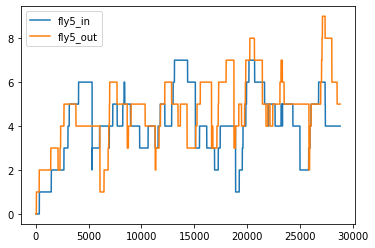

In [20]:
res[['fly5_in','fly5_out']].plot(legend=True)

In [33]:
res

,fly1_in,fly2_in,fly3_in,fly4_in,fly5_in,fly6_in,fly7_in,fly8_in,fly9_in,fly10_in,...,fly3_out_w,fly7_out_w,fly8_in_w,fly9_out_w,fly7_in_w,fly10_out_w,fly9_in_w,fly8_out_w,fly10_in_w,fly4_out_w
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,7,5,2,1,4,3,3,1,5,3,...,0,10,1,9,5,8,8,2,4,7
28796,7,5,2,1,4,3,3,1,5,3,...,0,10,1,9,5,8,8,2,4,7
28797,7,5,2,1,4,3,3,1,5,3,...,0,10,1,9,5,8,8,2,4,7
28798,7,5,2,1,4,3,3,1,5,3,...,0,10,1,9,5,8,8,2,4,7


<Axes: >

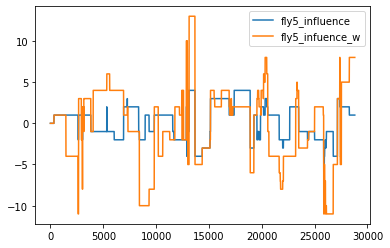

In [21]:
res_influence[['fly5_influence', 'fly5_infuence_w']].plot()